In [ ]:
import os
import re
import sys
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import glob
import pickle
import pandas as pd

### CLIP installation & import

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import clip

### ALIGN installation & import

In [ ]:
from transformers import AlignProcessor, AlignModel

### BLIP-2 installation & import

In [ ]:
!pip install salesforce-lavis
from lavis.models import load_model_and_preprocess

## Abstract class Retriever


In [ ]:
class Retriever:
    def __init__(self) -> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.image_IDs = []
        self.image_encodings = None

    def encode_images(self, images_paths ,out_dir=None, batch_size=50):
        pass

    def encode_text(self, text):
        pass

    def compare_to_images(self, text):  # Returns a sorted list of tuples (cosine_similarity, Image_ID)
        text_encoding = self.encode_text(text).T
        cosine_similarities = torch.mm(self.image_encodings, text_encoding)
        return sorted(zip(cosine_similarities.tolist(),self.image_IDs),reverse=True)

    def load_encoded_images(self, directory, model_name):
        # Load tensor from file
        self.image_encodings = torch.load(directory + f'/{model_name}_image_encodings.pth')
        # Load list from file
        with open(directory + f'/{model_name}_images_IDs.pkl', 'rb') as f:
            self.image_IDs = pickle.load(f)

    def plot_top_images(self, sorted_list, n, querry):
        # Create subplots
        fig, axes = plt.subplots(1, n, figsize=(15, 5))

        plt.suptitle("Querry: '" + querry + "'", x=0.1, y=0.95, fontsize=16, ha='left')
        # Display the top n images
        for i in range(min(len(sorted_list), n)):
            _, image_path = sorted_list[i]
            image_path =  image_path
            try:
                # Display the image using matplotlib.image
                img = mpimg.imread(image_path)
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f"Similarity: {round(sorted_list[i][0],4)}")
            except Exception as e:
                print(f"Error displaying image {image_path}: {e}")

        plt.tight_layout()
        plt.show()

In [ ]:
class CLIPRetriever(Retriever):
    def __init__(self) -> None:
        super().__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)

    def encode_images(self, images_paths ,out_dir=None, batch_size=50):
        batches  = [images_paths[i:i+batch_size] for i in range(0, len(images_paths), batch_size)]
        self.image_IDs = []
        self.image_encodings = None
        for batch in batches:
            images = []

            # Preprocess Images
            for image_name in batch:
                images.append(Image.open(image_name))
                self.image_IDs.append(image_name)

            preprocessed_images = []
            for image in images:
                image_input = self.preprocess(image).unsqueeze(0).to(self.device)
                preprocessed_images.append(image_input)
            preprocessed_images = torch.cat(preprocessed_images)
            del images

            # Encode Images
            with torch.no_grad():
                if self.image_encodings is None:
                    self.image_encodings = self.model.encode_image(preprocessed_images)
                else:
                    self.image_encodings = torch.cat((self.image_encodings, self.model.encode_image(preprocessed_images)), dim=0)

        self.image_encodings = F.normalize(self.image_encodings, p=2, dim=-1)
        # Save if out_dir specified
        if out_dir is not None and self.image_encodings is not None:
            torch.save(self.image_encodings, out_dir + '/CLIP_image_encodings.pth')
            with open(out_dir + '/CLIP_images_IDs.pkl', 'wb') as f:
                pickle.dump(self.image_IDs, f)

    def encode_text(self, text):
        # Preprocess text
        text = clip.tokenize(text).to(self.device)

        # Encode text
        with torch.no_grad():
            encoded_text = self.model.encode_text(text)
        return encoded_text

In [ ]:
class ALIGNRetriever(Retriever):
    def __init__(self) -> None:
        super().__init__()
        self.preprocess = AlignProcessor.from_pretrained("kakaobrain/align-base")
        self.model = AlignModel.from_pretrained("kakaobrain/align-base")

    def encode_images(self, images_paths ,out_dir=None, batch_size=50):
        batches  = [images_paths[i:i+batch_size] for i in range(0, len(images_paths), batch_size)]
        self.image_IDs = []
        self.image_encodings = None
        for batch in batches:
            images = []

            # Preprocess Images
            for image_name in batch:
                images.append(Image.open(image_name))
                self.image_IDs.append(image_name)

            preprocessed_input = self.preprocess(text="",images=images, return_tensors="pt")
            del images

            # Encode Images
            with torch.no_grad():
                outputs = self.model(**preprocessed_input)
                if self.image_encodings is None:
                    self.image_encodings = outputs.image_embeds
                else:
                    self.image_encodings = torch.cat((self.image_encodings, outputs.image_embeds), dim=0)

        self.image_encodings = F.normalize(self.image_encodings, p=2, dim=-1)
        # Save if out_dir specified
        if out_dir is not None and self.image_encodings is not None:
            torch.save(self.image_encodings, out_dir + '/ALIGN_image_encodings.pth')
            with open(out_dir + '/ALIGN_images_IDs.pkl', 'wb') as f:
                pickle.dump(self.image_IDs, f)

    def encode_text(self, text):
        # Preprocess text
        there_must_be_picture = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)  # I don't like it either
        preprocessed_input = self.preprocess(text=text,images=there_must_be_picture, return_tensors="pt")

        # Encode text
        outputs = self.model(**preprocessed_input)
        return outputs.text_embeds

In [ ]:
class BLIP2Retriever(Retriever):
    def __init__(self) -> None:
        super().__init__()
        self.model, self.vis_processors, self.txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain_vitL", is_eval=True, device=self.device)

    def encode_images(self, images_paths, out_dir=None, batch_size=50):
        batches  = [images_paths[i:i+batch_size] for i in range(0, len(images_paths), batch_size)]
        self.image_IDs = []
        self.image_encodings = None
        for batch in batches:
            images = []

            # Preprocess Images
            for image_name in batch:
                images.append(Image.open(image_name).convert('RGB'))
                self.image_IDs.append(image_name)

            preprocessed_images = []
            for image in images:
                image_input = self.vis_processors["eval"](image).unsqueeze(0).to(self.device)
                preprocessed_images.append(image_input)
            preprocessed_images = torch.cat(preprocessed_images)
            del images

            # Build sample
            sample = {"image": preprocessed_images, "text_input": []}

            # Encode Images
            new_encodings = self.model.extract_features(sample, mode="image").image_embeds[:,0,:]
            if self.image_encodings is None:
                self.image_encodings = new_encodings
            else:
                self.image_encodings = torch.cat((self.image_encodings, new_encodings), dim=0)

            self.image_encodings = F.normalize(self.image_encodings, p=2, dim=-1)
            # Save if out_dir specified
            if out_dir is not None and self.image_encodings is not None:
                torch.save(self.image_encodings, out_dir + '/BLIP2_image_encodings.pth')
                with open(out_dir + '/BLIP2_images_IDs.pkl', 'wb') as f:
                    pickle.dump(self.image_IDs, f)

    def encode_text(self, text):
        # Preprocess text
        text = self.txt_processors["eval"](text)

        # Build sample
        sample = {"image": torch.randn(1, 3, 50, 50), "text_input": [text]}

        # Encode text
        encoded_text = self.model.extract_features(sample, mode="text").text_embeds[0,0,:]
        encoded_text = torch.unsqueeze(encoded_text, dim=0)
        return encoded_text


In [ ]:
def list_files(directory):
    return glob.glob(os.path.join(directory, "*.jpeg")) + glob.glob(os.path.join(directory, "*.jpg")) + glob.glob(os.path.join(directory, "*.png")) + glob.glob(os.path.join(directory, "*.JPG")) + glob.glob(os.path.join(directory, "*.JPEG"))

def find_rank(list_of_tuples, ID):
    for index, (cosine_similarity, Image_ID) in enumerate(list_of_tuples):
        if Image_ID.endswith(ID):
            return index
    return -1  # Return -1 if ID not found in any Image_ID

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
!ls
!cd drive
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data
cat: sample_data: Is a directory
/content


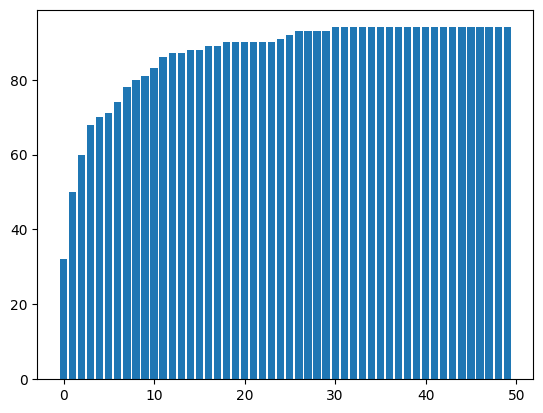

In [ ]:
r = BLIP2Retriever()
images_dir = os.getcwd() + "/drive/MyDrive/data"
save_dir = os.getcwd() + "/drive/MyDrive/saves"
# r.encode_images(list_files(directory=images_dir),out_dir=save_dir)
r.load_encoded_images(save_dir,model_name='BLIP2')


ranks_cumulation = [0] * len(r.image_IDs)
df = pd.read_csv(images_dir+'/labels.csv')
for id,label in zip(df.ID,df.label):
    ordered_images = r.compare_to_images(label)
    rank = find_rank(ordered_images, id)
    ranks_cumulation[rank:] = [x+1 for x in ranks_cumulation[rank:]]
    # ranks_cumulation[rank] += 1

plt.bar(range(len(ranks_cumulation[:50])),ranks_cumulation[:50])
plt.show()